In [1]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow.keras import layers
import h5py
import math
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.linalg import expm
from sklearn.preprocessing import MinMaxScaler
from numpy import inf, nan
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable 
%run my_functions.ipynb 

2023-01-09 15:34:37.978514: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
## Select GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
tf_device = '/gpu:1'

In [3]:
## Data Loading . . . orignally network trained with 40 million dataset
# Tissue parameters
train_y_file = scipy.io.loadmat ('data/Train_Y.mat')
Train_Y = train_y_file['Train_Y']
## MTC signal at 1uT
mtc_file_1p0_file = scipy.io.loadmat('data/MTC_ref_1p0.mat')
MTC_ref_1p0 = mtc_file_1p0_file['MTC_ref_1p0']
## MTC signal at 1.5uT
mtc_file_1p5_file = scipy.io.loadmat('data/MTC_ref_1p5.mat')
MTC_ref_1p5 = mtc_file_1p5_file['MTC_ref_1p5']

# MTC-MRF signals only for testing, GT for deepBS
train_x_file = scipy.io.loadmat('data/TrainInput_noisy.mat') 
Train_X_all = train_x_file['TrainInput_noisy']

In [ ]:
## Load trained deep Bloch simulator to generated MTC-MRF signals from tissue parameters
model_BS_40DS = tf.keras.models.load_model('saved_models/deep_BS_RNN_40')

## Load trained deep Bloch simulator to generated Zref signals at 1uT and 1.5 uT
model_BS_2_point = tf.keras.models.load_model('saved_models/deep_BS_2_outputs')

In [7]:
scaler_in = MinMaxScaler()
## Scale tissue parameters (0, 1)
Train_Y_fit = scaler_in.fit_transform(np.squeeze(Train_Y))
start = time.time()
## Estimation of MTC-MRF signals
Train_X_estimated = model_BS_40DS.predict(np.expand_dims(Train_Y_fit,2))
end = time.time()
print(f"Runtime of dataset is {end - start}")
## Add noise to network simulated model, SNR=46
Train_X = mtc_mrf_noisy (np.squeeze(Train_X_estimated), 46)

Runtime of dataset is 0.40581488609313965


RMSE %:  0.5159607622772455


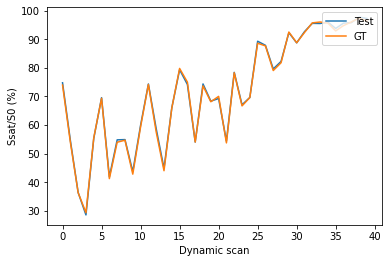

In [8]:
## Testing of deepBS for MTC-MRF simulation

print('RMSE %: ', mean_squared_error(Train_X_estimated, Train_X_all , squared=False)*100)
plt.plot( Train_X_estimated[0]*100)
plt.plot( Train_X_all[0]*100)
plt.ylabel('Ssat/S0 (%)')
plt.xlabel('Dynamic scan')
plt.legend(['Test', 'GT'], loc='upper right')

In [9]:
##   Traning and Testing Split 9:1 ratio
split = int(0.9 * len(Train_X))
x_train = Train_X[0:split]
x_test  = Train_X[split:]
GT_train = Train_Y[0:split]          ## kmw, M0m, T2m, T1w, T1w/T2w
GT_test = Train_Y[split:]

t1t2w_para_train = GT_train [:,4:5]         ## T1w/T2w
t1t2w_para_test = GT_test [:,4:5]    

Zref_1p0_train = MTC_ref_1p0[0:split]
test_MTC_ref_1p0_test = MTC_ref_1p0[split:]
Zref_1p5_train = MTC_ref_1p5[0:split]
test_MTC_ref_1p5_test = MTC_ref_1p5[split:]

Zref at 1 uT RMSE %:  0.2999757183715701
Zref at 1 uT RMSE %:  0.30794967897236347


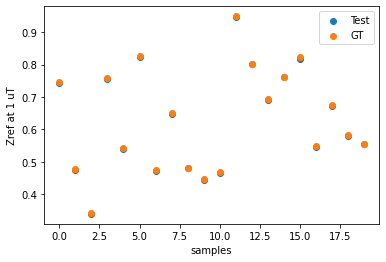

In [10]:
## Testing of deepBS for generating Zref signals at 1uT and 1.5 uT

GT_test_scaled = scaler_in.fit_transform(GT_test)
estimated_zref = model_BS_2_point (np.expand_dims(GT_test_scaled,2))

print('Zref at 1 uT RMSE %: ', mean_squared_error(estimated_zref[:,0], test_MTC_ref_1p0_test , squared=False)*100)
print('Zref at 1 uT RMSE %: ', mean_squared_error(estimated_zref[:,1], test_MTC_ref_1p5_test , squared=False)*100)
x_axis = range(20)
plt.scatter(x_axis, estimated_zref[0:20,0])
plt.scatter(x_axis, test_MTC_ref_1p0_test[0:20])
plt.ylabel('Zref at 1 uT')
plt.xlabel('samples')
plt.legend(['Test', 'GT'], loc='upper right')

In [ ]:
model_recn_RNN = tf.keras.models.load_model('saved_models/BS_recon_RNN')

In [12]:
## Testing on numerical phantoms

file2=scipy.io.loadmat('data/numerical_phantom/GT_Rm_no_dM.mat')
Phantom_1 = file2['Rm_fixed1']   
file3=scipy.io.loadmat('data/numerical_phantom/GT_Mm_no_dM.mat')
Phantom_2 = file3['Mm_fixed1']   
file4=scipy.io.loadmat('data/numerical_phantom/GT_T2m_no_dM.mat')
Phantom_3 = file4['T2m_fixed1']   
file8=scipy.io.loadmat('data/numerical_phantom/GT_T1_no_dM.mat')
Phantom_4 = file8['T1_fixed1']  

file1=scipy.io.loadmat('data/numerical_phantom/mtc_mrf0_no_dM.mat')  
mtc2 = file1['mtc_mrf0'] 
file1=scipy.io.loadmat('data/numerical_phantom/mtc_mrf1_no_dM.mat') 
mtc3 = file1['mtc_mrf1'] 
file1=scipy.io.loadmat('data/numerical_phantom/mtc_mrf2_no_dM.mat')   
mtc4 = file1['mtc_mrf2'] 
file1=scipy.io.loadmat('data/numerical_phantom/mtc_mrf3_no_dM.mat')  
mtc8 = file1['mtc_mrf3'] 

error_rm = []
error_cm =[]
error_t2m =[]
error_t1w = []
for i in range(1):
    mtc22 = mtc_mrf_noisy(mtc2, 100)
    mtc33 = mtc_mrf_noisy(mtc3, 100)
    mtc44 = mtc_mrf_noisy(mtc4, 100)
    mtc88 = mtc_mrf_noisy(mtc8, 100)

    x_test_no_noise21 = np.expand_dims(mtc22,axis=2)
    x_test_no_noise31 = np.expand_dims(mtc33,axis=2)
    x_test_no_noise41 = np.expand_dims(mtc44,axis=2)
    x_test_no_noise81 =  np.expand_dims(mtc88,axis=2)

    x_pred_mtc1 = model_recn_RNN.predict(x_test_no_noise21)
    test_Rm_reshaped = np.transpose(np.reshape(x_pred_mtc1[:,0], [150,30]))
    x_pred_mtc2 = model_recn_RNN.predict(x_test_no_noise31)
    test_Mm_reshaped = np.transpose(np.reshape(x_pred_mtc2[:,1], [150,30]))
    x_pred_mtc3 = model_recn_RNN.predict(x_test_no_noise41)
    test_T2m_reshaped = np.transpose(np.reshape(x_pred_mtc3[:,2], [150,30]))
    x_pred_mtc4 = model_recn_RNN.predict(x_test_no_noise81)
    test_T1w_reshaped = np.transpose(np.reshape(x_pred_mtc4[:,3], [150,30]))


    out_norm_rate = NormalizeData(Phantom_1)
    GT_norm_rate = NormalizeData(test_Rm_reshaped) 
    out_norm_conc = NormalizeData(Phantom_2)
    GT_norm_conc = NormalizeData(test_Mm_reshaped)  
    out_norm_rate_m = NormalizeData(Phantom_3)
    GT_norm_rate_m = NormalizeData(test_T2m_reshaped)   
    out_norm_conc_m = NormalizeData(Phantom_4)
    GT_norm_conc_m = NormalizeData(test_T1w_reshaped) 

    _rm = mean_squared_error(out_norm_rate, GT_norm_rate , squared=False)
    _cm = mean_squared_error(out_norm_conc, GT_norm_conc , squared=False)
    _t2m = mean_squared_error(out_norm_rate_m, GT_norm_rate_m , squared=False)
    _t1w = mean_squared_error(out_norm_conc_m, GT_norm_conc_m, squared=False)
    error_rm.append(_rm)
    error_cm.append(_cm)
    error_t2m.append(_t2m)
    error_t1w.append(_t1w)
    

In [13]:
print(np.mean(error_rm)*100)
print(np.mean(error_cm)*100)
print(np.mean(error_t2m)*100)
print(np.mean(error_t1w)*100)

9.147193417227689
2.410025107505404
1.051973194508306
0.7710690852440928


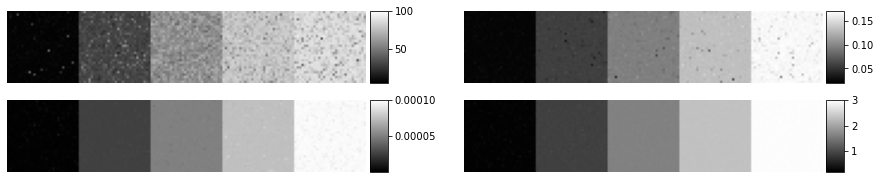

In [14]:
plt.figure(figsize=(15,3))
ax=plt.subplot(2,2,1)
plt.axis('off')
sc_t1w=plt.imshow(test_Rm_reshaped, cmap='gray')
sc_t1w.set_clim(5, 100)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc_t1w, cax=cax)

ax=plt.subplot(2,2,2)
plt.axis('off')
sc_t1w=plt.imshow(test_Mm_reshaped, cmap='gray')
sc_t1w.set_clim(0.02, 0.17)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc_t1w, cax=cax)

ax=plt.subplot(2,2,3)
plt.axis('off')
sc_t1w=plt.imshow(test_T2m_reshaped, cmap='gray')
sc_t1w.set_clim(0.000001, 0.0001)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc_t1w, cax=cax)

ax=plt.subplot(2,2,4)
plt.axis('off')
sc_t1w=plt.imshow(test_T1w_reshaped, cmap='gray')
sc_t1w.set_clim(0.2, 3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc_t1w, cax=cax)